In [1]:
#from sympy import conjugate
from torch.autograd import Variable
import torch
from rsvg import rsvg
from rdmg import rdm_ginibre
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def gen_paulis():
    Paulis = Variable(torch.zeros([3, 2, 2], dtype=torch.complex128), requires_grad=False)
    aux = 0
    for i in range(0,d,3):
        Paulis[i+aux] = torch.tensor([[0, 1], [1, 0]])        
        Paulis[i+1+aux] = torch.tensor([[0, -1j], [1j, 0]])
        Paulis[i+2+aux] = torch.tensor([[1, 0], [0, -1]])
        aux += 2
    return Paulis

def init_state_rsvg(n_qb):
    d = 2**n_qb
    target_vector = rsvg(d)
    target_op = np.outer(target_vector.conj(), target_vector)
    target_op = torch.tensor(target_op)
    return target_vector, target_op

def init_state_rdm_ginibre(n_qb):
    d = 2**n_qb
    rho = rdm_ginibre(d)
    print(np.trace(np.dot(rho,rho)))
    target_op = torch.tensor(rho)
    return target_op

def init_state_exp_val(d):
    rrho = rdm_ginibre(4)
    Paulis = gen_paulis(d)
    target_vector = [np.trace(np.real(np.dot(rrho,i))) for i in Paulis]
    target_vector = Variable(torch.tensor(target_vector ))
    return target_vector

def get_device(n_qubit):
    device = qml.device('qiskit.aer', wires=n_qubit, backend='qasm_simulator')
    return device

def random_params(n):
    params = np.random.normal(0,np.pi/2, n)
    params = Variable(torch.tensor(params), requires_grad=True)
    return params

def fidelidade(circuit, params, target_op):
    return circuit(params, M=target_op).item()

def cost(circuit, params, alpha):
    L = (1-(circuit(params, M=alpha)))**2
    return L

def train(epocas, circuit, params, alpha):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(circuit, params, alpha)
    best_params = 1*params
    f=[]
    for epoch in range(epocas):
        opt.zero_grad()
        loss = cost(circuit, params, alpha)
        print(epoch, loss.item())
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
        f.append(fidelidade(circuit, best_params, alpha))
    return best_params, f

# Iniciando o estado aleatório com rdm_ginibre

(0.5131876764866805+0j)
tensor([[ 0.3763+0.0000j, -0.1576+0.0857j,  0.1935+0.1016j,  0.1088+0.0294j],
        [-0.1576-0.0857j,  0.3557+0.0000j, -0.0411-0.0351j,  0.0589-0.0201j],
        [ 0.1935-0.1016j, -0.0411+0.0351j,  0.1529+0.0000j,  0.0681-0.0138j],
        [ 0.1088-0.0294j,  0.0589+0.0201j,  0.0681+0.0138j,  0.1152+0.0000j]],
       dtype=torch.complex128)


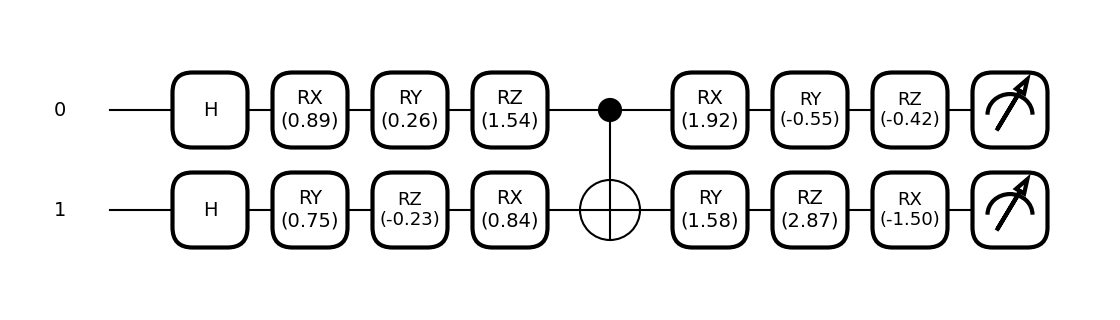

In [3]:
n_qubits = 2
n = 6*n_qubits
alpha = init_state_rdm_ginibre(n_qubits)
print(alpha)
params = random_params(n)
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return qml.expval(qml.Hermitian(M, wires=[0,1]))
#drawer = qml.draw(circuit)
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()

0 0.45572290605358595
1 0.35280281486808523
2 0.2622301014151547
3 0.23311735001321376
4 0.20393373468321666
5 0.1900186659925191
6 0.1730024751815223
7 0.1655234504770978
8 0.15883526459377448
9 0.15938161300429313
10 0.15886798578273556
11 0.15325682324987622
12 0.14562313195395538
13 0.1417444104205672
14 0.13858948964213258
15 0.13208061306514435
16 0.13147793604677507
17 0.1303052480486759
18 0.13336014587770076
19 0.13328963511228184
20 0.13539561805435824
21 0.13767409856959406
22 0.1346867165147189
23 0.13208205575988521
24 0.13418407193631335
25 0.1288346063034548
26 0.12943262934297703
27 0.1281239828527748
28 0.1278794580938054
29 0.12528091737186203
30 0.12336051501005904
31 0.12408171829235487
32 0.12473681229531725
33 0.12497154851757766
34 0.12541765584556347
35 0.12428517048935615
36 0.1270042000401917
37 0.12618253376005195
38 0.12600770445555143
39 0.12463115155662614
40 0.1265002047425728
41 0.12445810091094435
42 0.12535605418929763
43 0.1253936310448063
44 0.123841

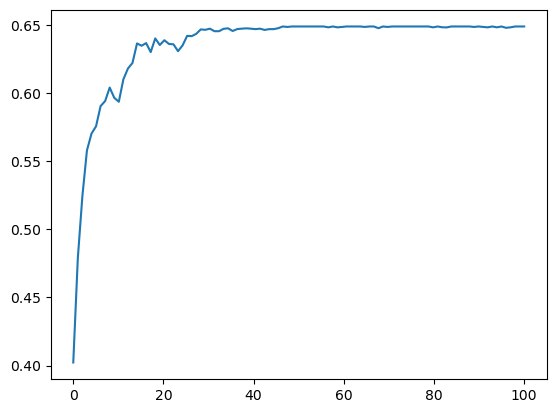

In [4]:
best_params, f = train(100, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()


In [6]:
print('Fidelidade = ',fidelidade(circuit, best_params, alpha))

Fidelidade =  0.6484841748615455


In [5]:
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit_p(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return  qml.probs(wires=[0,1])
counts = circuit_p(best_params, M=alpha)
print(counts)
prepared_state = counts.detach().numpy()**0.5
#print(target_vector)
print(alpha.detach().numpy())
print('------------------------')
print(prepared_state)
print(np.outer(prepared_state,prepared_state))

tensor([0.5234, 0.2725, 0.1670, 0.0371], dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)
[[ 0.37626711+0.j         -0.15759332+0.08571461j  0.19346076+0.10156826j
   0.10877248+0.02942129j]
 [-0.15759332-0.08571461j  0.35566765+0.j         -0.04106124-0.03506653j
   0.0588897 -0.02006553j]
 [ 0.19346076-0.10156826j -0.04106124+0.03506653j  0.15286316+0.j
   0.06808625-0.01383325j]
 [ 0.10877248-0.02942129j  0.0588897 +0.02006553j  0.06808625+0.01383325j
   0.11520208+0.j        ]]
------------------------
[0.72348981 0.52197791 0.40864678 0.19263794]
[[0.5234375  0.3776457  0.29565178 0.13937158]
 [0.3776457  0.27246094 0.21330459 0.10055275]
 [0.29565178 0.21330459 0.16699219 0.07872087]
 [0.13937158 0.10055275 0.07872087 0.03710937]]


# Iniciando o estado aleatório com rsvg

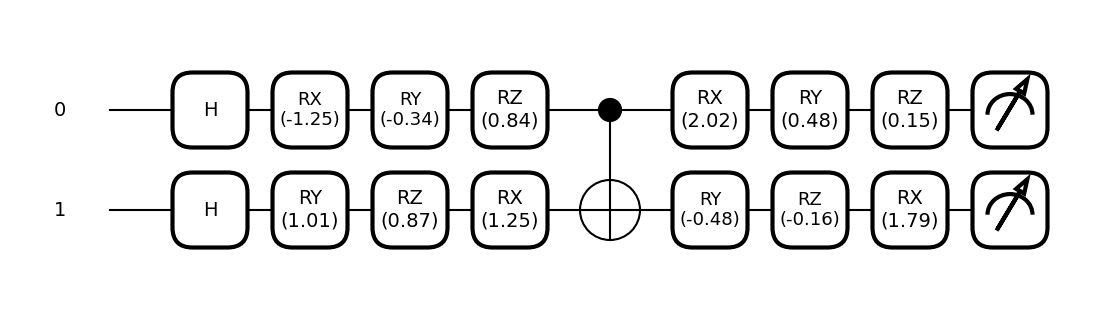

In [7]:
n_qubits = 2
n = 6*n_qubits
target_vector, alpha = init_state_rsvg(n_qubits)

params = random_params(n)
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return qml.expval(qml.Hermitian(M, wires=[0,1]))
#drawer = qml.draw(circuit)
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()

0 0.8019342422485352
1 0.6073036193847656
2 0.4154205322265625
3 0.2668771743774414
4 0.1837930679321289
5 0.12566471099853516
6 0.0970468521118164
7 0.06397342681884766
8 0.0428619384765625
9 0.0396881103515625
10 0.0282135009765625
11 0.021172523498535156
12 0.011330604553222656
13 0.007218360900878906
14 0.0080718994140625
15 0.005364418029785156
16 0.002017974853515635
17 0.002780914306640625
18 0.0033197402954101693
19 0.0027809143066406367
20 0.0022897720336914062
21 0.002384185791015625
22 0.002384185791015625
23 0.0022897720336914062
24 0.0016031265258789062
25 0.0021066665649414167
26 0.0010385513305664062
27 0.0011682510375976562
28 0.0014505386352539147
29 0.000976562500000007
30 0.0004205703735351608
31 0.0003089904785156289
32 0.000308990478515625
33 0.00034427642822266037
34 0.0004205703735351608
35 0.00034427642822266037
36 0.00046157836914062977
37 0.00038146972656250434
38 6.103515625000173e-05
39 7.724761962890625e-05
40 9.536743164062717e-05
41 0.00024414062500000347

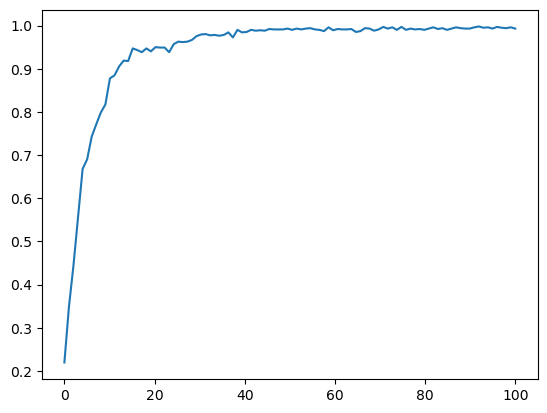

In [8]:
best_params, f = train(100, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

In [11]:
print('Fidelidade = ',fidelidade(circuit, best_params, alpha))

Fidelidade =  0.9951171874999999


In [12]:
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit_p(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    qml.Hadamard(wires=1)
    qml.RY(params[3], wires=1)
    qml.RZ(params[4], wires=1)
    qml.RX(params[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(params[6], wires=0)
    qml.RY(params[7], wires=0)
    qml.RZ(params[8], wires=0)

    qml.RY(params[9], wires=1)
    qml.RZ(params[10], wires=1)
    qml.RX(params[11], wires=1)
    return  qml.probs(wires=[0,1])
counts = circuit_p(best_params, M=alpha)
print(counts)
prepared_state = counts.detach().numpy()**0.5
print(target_vector)
print(alpha.detach().numpy())
print('------------------------')
print(prepared_state)
print(np.outer(prepared_state,prepared_state))

tensor([0.1953, 0.0859, 0.4443, 0.2744], dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)
[-0.10418639+0.44250651j -0.13166609-0.18125312j  0.04999019+0.65957495j
 -0.45022131-0.32079148j]
[[ 0.20666682+0.j         -0.06648787+0.07714721j  0.28665791-0.09083972j
  -0.09504539+0.23264797j]
 [-0.06648787-0.07714721j  0.05018865+0.j         -0.12613203-0.07778277j
   0.11742333-0.03936666j]
 [ 0.28665791+0.09083972j -0.12613203+0.07778277j  0.43753813+0.j
  -0.23409267+0.28091827j]
 [-0.09504539-0.23264797j  0.11742333+0.03936666j -0.23409267-0.28091827j
   0.3056064 +0.j        ]]
------------------------
[0.44194174 0.29315098 0.66658528 0.52384546]
[[0.1953125  0.12955566 0.29459186 0.23150917]
 [0.12955566 0.0859375  0.19541013 0.15356581]
 [0.29459186 0.19541013 0.44433594 0.34918767]
 [0.23150917 0.15356581 0.34918767 0.27441406]]


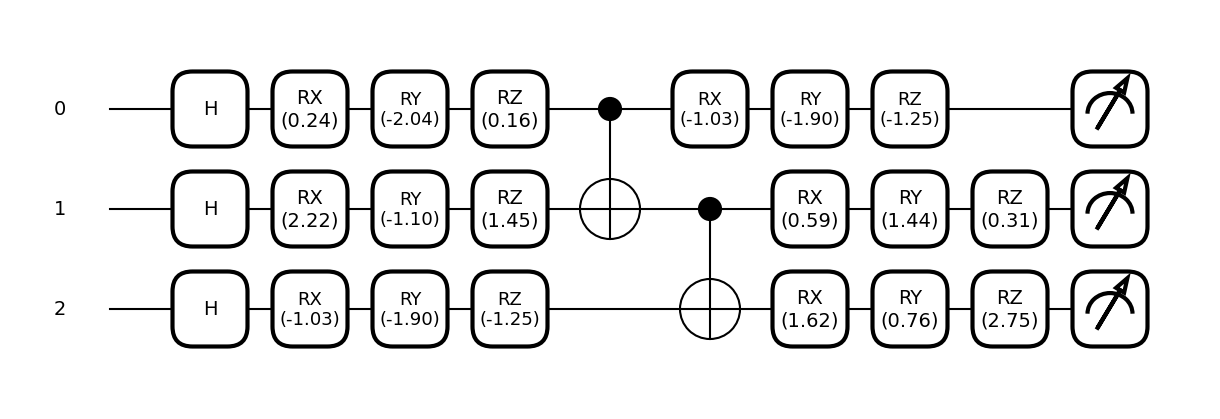

In [13]:
n_qubits = 3
n = 6*n_qubits
#alpha = init_state_rdm_ginibre(n_qubits)
target_vector, alpha = init_state_rsvg(n_qubits)

params = random_params(n)
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    #n_qubits = 5
    n = 6*n_qubits
    w = []

    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        w.append(i)

    aux = 0
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2

    return qml.expval(qml.Hermitian(M, wires=w))
fig, ax = qml.draw_mpl(circuit, decimals=2)(params, alpha)
plt.show()


0 0.849853515625
1 0.7152137756347656
2 0.6506690979003906
3 0.5421791076660157
4 0.4179420471191408
5 0.360703468322754
6 0.30551528930664074
7 0.2539215087890626
8 0.24128818511962902
9 0.2088775634765626
10 0.1829566955566407
11 0.19570255279541027
12 0.17551517486572274
13 0.1541175842285157
14 0.145798683166504
15 0.12635803222656258
16 0.12428379058837899
17 0.10959720611572273
18 0.07476806640625006
19 0.08755588531494148
20 0.060562133789062556
21 0.047425270080566455
22 0.0400781631469727
23 0.03299331665039067
24 0.02627944946289066
25 0.02350711822509769
26 0.02502822875976566
27 0.020328521728515656
28 0.021172523498535187
29 0.01763916015625003
30 0.02380752563476566
31 0.021744728088378937
32 0.020328521728515656
33 0.02596378326416019
34 0.015870094299316434
35 0.019229888916015656
36 0.016616821289062528
37 0.019229888916015656
38 0.016117095947265653
39 0.017899513244628937
40 0.014194488525390651
41 0.013962745666503932
42 0.00878906250000002
43 0.009159088134765646
4

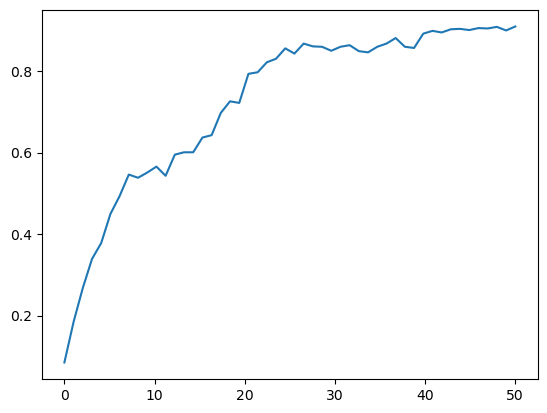

In [14]:
best_params, f = train(50, circuit, params, alpha)
x = np.linspace(0,len(f),len(f))
plt.plot(x,f)
plt.show()

In [17]:
print('Fidelidade = ',fidelidade(circuit, best_params, alpha))

Fidelidade =  0.9130859374999999


In [16]:
n_qubits = 3
device = get_device(n_qubits)

@qml.qnode(device, interface="torch")
def circuit_p(params, M=None):
    #n_qubits = 5
    n = 6*n_qubits
    w = []

    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        w.append(i)

    aux = 0
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])
    for j in range(n_qubits):
        qml.RX(params[j+aux], wires=j)
        qml.RY(params[j+1+aux], wires=j)
        qml.RZ(params[j+2+aux], wires=j)
        aux+=2
    
    return  qml.probs(wires=w)

counts = circuit_p(best_params, M=alpha)
print(counts)
prepared_state = counts.detach().numpy()**0.5
print(target_vector)
print(alpha.detach().numpy())
print('------------------------')
print(prepared_state)
print(np.outer(prepared_state,prepared_state))

tensor([0.0420, 0.6123, 0.0254, 0.0117, 0.0166, 0.2471, 0.0234, 0.0215],
       dtype=torch.float64, grad_fn=<SqueezeBackward0>)
[-0.23371353-0.06654657j -0.54164721+0.53016942j -0.05510351-0.0875761j
 -0.05112411+0.03326835j  0.20133769+0.18825432j -0.18686297-0.45014398j
 -0.10602868-0.14673494j  0.07580775+0.00422233j]
[[ 5.90504594e-02+0.j          9.13093258e-02-0.15995253j
   1.87063245e-02+0.01680077j  9.73450074e-03-0.0111774j
  -5.95830208e-02-0.03059925j  7.36279419e-02+0.09276965j
   3.45450440e-02+0.0272381j  -1.79982793e-02+0.00405793j]
 [ 9.13093258e-02+0.15995253j  5.74461317e-01+0.j
  -1.65835106e-02+0.07664955j  4.53290940e-02+0.00908473j
  -9.24731722e-03-0.20871051j -1.37438767e-01+0.34288827j
  -2.03642388e-02+0.13569174j -3.88225052e-02-0.04247797j]
 [ 1.87063245e-02-0.01680077j -1.65835106e-02-0.07664955j
   1.07059705e-02+0.j         -9.63951483e-05-0.00631045j
  -2.75809925e-02+0.0072589j   4.97186613e-02+0.00843978j
   1.86930266e-02-0.00119997j -4.54704872e-03